## German Perea 

#### Planning for prices for SlrpEV project using the Day Ahead Market approach

In [ ]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import logging
import seaborn as sns
import csv
import zipfile
from pathlib import Path



In [66]:
#Read csv data: Alameda_nodel.csv

alameda = pd.read_csv('Alameda_node1_dam.csv')


In [67]:
# The data is in interval of 1 hour 

alameda['INTERVALSTARTTIME_GMT'] = pd.to_datetime(alameda['INTERVALSTARTTIME_GMT'])


In [68]:
alameda['INTERVALENDTIME_GMT'] = pd.to_datetime(alameda['INTERVALENDTIME_GMT'])


In [69]:
# Operational time is in 24 hour, MW
# The attributes: OPR_DT, OPR_HR 

In [70]:
# We are interested in Energy only, the symbol for this MCE

alameda_Energy = alameda[alameda['LMP_TYPE']=='MCE'].reset_index(drop=True)


In [71]:
# For simplicity, use X instead of alameda_Energy
X = alameda_Energy


Text(0.5, 1.0, 'Energy')

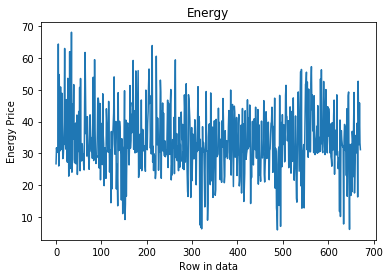

In [72]:
plt.plot(np.arange(len(X)),X['MW'][0:len(X)])
plt.ylabel('Energy Price')
plt.xlabel('Row in data')
plt.title('Energy')



In [73]:
start = pd.to_datetime(pd.Series(np.asarray(X['INTERVALSTARTTIME_GMT'], dtype='datetime64[ms]')))
end = pd.to_datetime(pd.Series(np.asarray(X['INTERVALENDTIME_GMT'], dtype='datetime64[ms]')))
start_pacific = start.dt.tz_localize('GMT').dt.tz_convert('US/Pacific')


In [74]:
X['OPR_DT'] = pd.to_datetime(X['OPR_DT'])

In [100]:
X.sort_values(by = ['OPR_DT', 'OPR_HR']).reset_index(drop=True).head(5)


,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,OPR_DT,OPR_HR,OPR_INTERVAL,NODE_ID_XML,NODE_ID,NODE,MARKET_RUN_ID,LMP_TYPE,XML_DATA_ITEM,PNODE_RESMRID,GRP_TYPE,POS,MW,GROUP,DoW,Week,Year
0,2021-01-04 08:00:00,2021-01-04 09:00:00,2021-01-04,1,0,ALAMEDA_LNODELD1,ALAMEDA_LNODELD1,ALAMEDA_LNODELD1,DAM,MCE,LMP_ENE_PRC,ALAMEDA_LNODELD1,ALL,1,31.02839,3,0,1,2021
1,2021-01-04 09:00:00,2021-01-04 10:00:00,2021-01-04,2,0,ALAMEDA_LNODELD1,ALAMEDA_LNODELD1,ALAMEDA_LNODELD1,DAM,MCE,LMP_ENE_PRC,ALAMEDA_LNODELD1,ALL,1,30.77623,3,0,1,2021
2,2021-01-04 10:00:00,2021-01-04 11:00:00,2021-01-04,3,0,ALAMEDA_LNODELD1,ALAMEDA_LNODELD1,ALAMEDA_LNODELD1,DAM,MCE,LMP_ENE_PRC,ALAMEDA_LNODELD1,ALL,1,30.28689,3,0,1,2021
3,2021-01-04 11:00:00,2021-01-04 12:00:00,2021-01-04,4,0,ALAMEDA_LNODELD1,ALAMEDA_LNODELD1,ALAMEDA_LNODELD1,DAM,MCE,LMP_ENE_PRC,ALAMEDA_LNODELD1,ALL,1,30.40642,3,0,1,2021
4,2021-01-04 12:00:00,2021-01-04 13:00:00,2021-01-04,5,0,ALAMEDA_LNODELD1,ALAMEDA_LNODELD1,ALAMEDA_LNODELD1,DAM,MCE,LMP_ENE_PRC,ALAMEDA_LNODELD1,ALL,1,31.74108,3,0,1,2021


In [76]:
#DoW = Day of week
X['DoW'] = X['OPR_DT'].dt.weekday
X['Week'] = X['OPR_DT'].dt.week
X['Year'] = X['OPR_DT'].dt.year

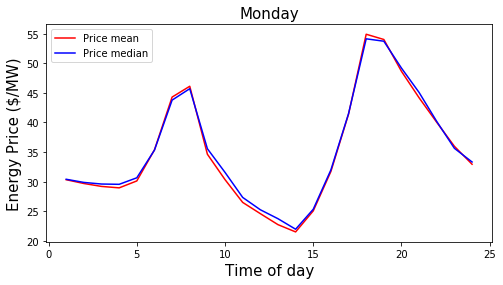

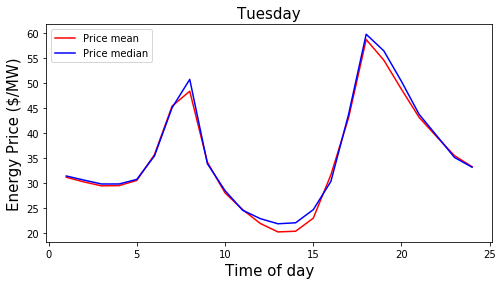

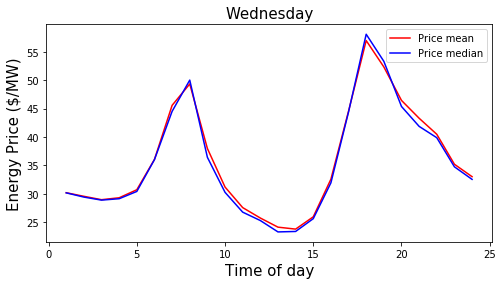

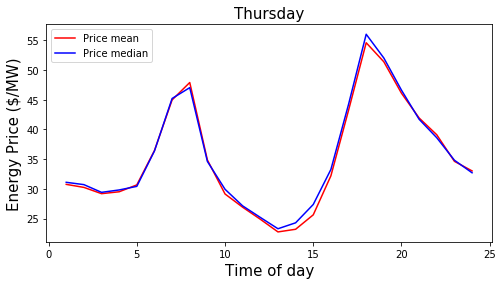

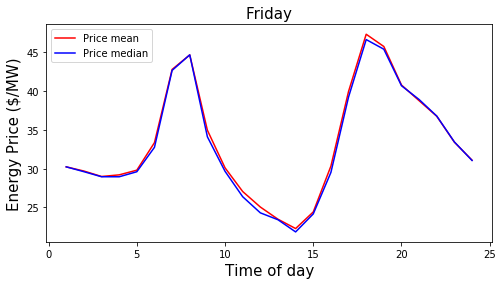

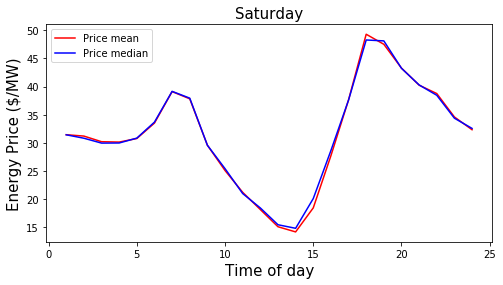

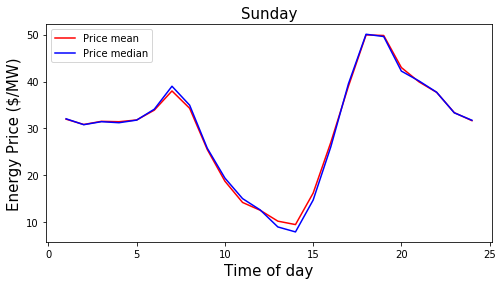

In [77]:
days_of_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in np.arange(7):
    #for each day of week
    idx = X['DoW']== i
    fig, ax = plt.subplots(figsize = (8,4))
    #Plot mean load shape across all weeks 
    X[idx].groupby('OPR_HR')['MW'].mean().plot(ax = ax, legend=False, color = 'red')
    X[idx].groupby('OPR_HR')['MW'].median().plot(ax = ax, legend=False, color = 'blue')
    
    ax.set_xlabel('Time of day', fontsize = 15)
    ax.set_ylabel('Energy Price ($/MW)',fontsize = 15)
    ax.legend(['Price mean', 'Price median'])
    ax.set_title(days_of_week[i], fontsize = 15)
    plt.show()


In [78]:
# Let's split the data, into 2 datasets to capture True Representation 
# Choose 2 days for Testin and 5 days for Training 

CV = X.groupby(['Year','Week','DoW']).size().index.get_level_values(1).value_counts()
tu = pd.DataFrame(CV).rename(columns = {'Week':'values'})
together = X.join(tu, on = 'Week')


In [79]:
# Normalize Price 
MN = together
MN['Normalized_Price'] = MN['MW']/MN['MW'].max()
bv = MN[['Week', 'values','OPR_DT']].apply(tuple, axis=1)
MN['Triple'] = bv 

bv2 =  MN[['Week', 'values']].apply(tuple, axis = 1)

MN['Pairs'] = bv2


In [80]:
L = MN['Triple'].unique()

el = pd.DataFrame({'We':[x[0] for x in L], 'Va': [x[1] for x in L], 'Date': [x[2] for x in L]})

tr = pd.DataFrame(el.groupby(['We','Va']).apply(lambda x: list(x['Date'])))

zero = tr.index.get_level_values(0)
one = tr.index.get_level_values(1)

gt = pd.DataFrame({'X':zero, 'Y':one}).apply(tuple, axis=1)



In [81]:
tr['Pairs'] = gt.values


In [82]:
tr = tr.reset_index(drop = True).rename(columns = {0: 'lstDates'})


In [83]:
# The following is how we are separating the data 
we = [x[0] for x in tr['Pairs']]
days = [x[1] for x in tr['Pairs']]



In [84]:
def trainSplit(dat):
    """Returns: dates that are suppose to go with
       train data"""
    np.random.seed(40)
    train = []
    we = [x[0] for x in dat['Pairs']] # the number of weeks
    days = [x[1] for x in dat['Pairs']] # the number of days
    ch = np.random.choice
    for i,j in zip(np.arange(len(we)), days):
            train.extend(ch(dat.iloc[i]['lstDates'], 5, replace = False))
            #Weeks with 7 days: extend 5 days
    return train


In [85]:
train_dates = trainSplit(tr)
MN = MN.drop(columns = ['NODE_ID_XML','NODE_ID','Pairs','GROUP','Triple','POS','GRP_TYPE','values','XML_DATA_ITEM'])

In [86]:
training_data = MN[MN['OPR_DT'].isin(train_dates)]
testing_data = MN[MN['OPR_DT'].isin(train_dates)==False]

In [87]:
import keras 
import sys
import sklearn 
import tensorflow as tf


In [88]:
MN = MN.sort_values(by=['OPR_DT','OPR_HR'])
MN.columns

Index(['INTERVALSTARTTIME_GMT', 'INTERVALENDTIME_GMT', 'OPR_DT', 'OPR_HR',
       'OPR_INTERVAL', 'NODE', 'MARKET_RUN_ID', 'LMP_TYPE', 'PNODE_RESMRID',
       'MW', 'DoW', 'Week', 'Year', 'Normalized_Price'],
      dtype='object')

In [89]:

n_steps = 168 # The toal hours in week 
data = MN[['Normalized_Price']].values

# A tuple with 3 values: (hours left, the hours of week + 24 hours, 
series_reshaped =  np.array([data[i:i + (n_steps+24)].copy() for i in range(len(data) - (n_steps+24))])

series_reshaped.shape


(480, 192, 1)

In [90]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [91]:
X_train = series_reshaped[:300, :n_steps] 
X_valid = series_reshaped[300:400, :n_steps] 
X_test = series_reshaped[400:, :n_steps] 
Y = np.empty((480, n_steps, 24))  
for step_ahead in range(1, 24 + 1):     
   Y[..., step_ahead - 1] =   series_reshaped[..., step_ahead:step_ahead + n_steps, 0]
 
Y_train = Y[:300] 
Y_valid = Y[300:400] 
Y_test = Y[400:]


In [92]:
np.random.seed(42)
tf.random.set_seed(42)
# The architecture of the Neural Network 
model6 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(24))
])



In [95]:
np.random.seed(30)
tf.random.set_seed(30)

model6.compile(loss="mse", optimizer="adam")
history = model6.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))


Epoch 1/20
10/10 [==============================] - 4s 178ms/step - loss: 0.0223 - val_loss: 0.0186
Epoch 2/20
10/10 [==============================] - 1s 91ms/step - loss: 0.0212 - val_loss: 0.0176
Epoch 3/20
10/10 [==============================] - 1s 141ms/step - loss: 0.0200 - val_loss: 0.0165
Epoch 4/20
10/10 [==============================] - 1s 95ms/step - loss: 0.0185 - val_loss: 0.0153
Epoch 5/20
10/10 [==============================] - 1s 88ms/step - loss: 0.0171 - val_loss: 0.0138
Epoch 6/20
10/10 [==============================] - 1s 91ms/step - loss: 0.0155 - val_loss: 0.0126
Epoch 7/20
10/10 [==============================] - 1s 88ms/step - loss: 0.0142 - val_loss: 0.0114
Epoch 8/20
10/10 [==============================] - 1s 93ms/step - loss: 0.0130 - val_loss: 0.0106
Epoch 9/20
10/10 [==============================] - 1s 93ms/step - loss: 0.0123 - val_loss: 0.0101
Epoch 10/20
10/10 [==============================] - 1s 94ms/step - loss: 0.0116 - val_loss: 0.0098
Epoch 1

In [96]:
Y_pred = model6.predict(X_test)
# Controlling tracing 

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][23]))
    

actual = pd.DataFrame((X_test[:,0]))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['percentage_error'] = 100*(actual['difference'])/(actual['actual'])


Text(0.5, 1.0, 'Testing set: Energy Price')

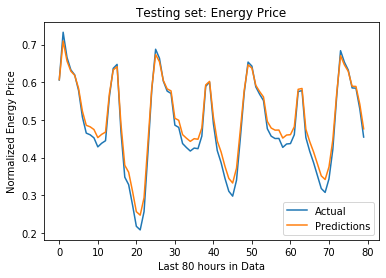

In [97]:
plt.plot(np.arange(len(actual)),actual['actual'][0:len(X)])
plt.plot(np.arange(len(actual)),actual['predictions'][0:len(X)])
plt.legend(['Actual','Predictions'])
plt.ylabel('Normalized Energy Price')
plt.xlabel('Last 80 hours in Data')
plt.title('Testing set: Energy Price')


Text(0.5, 1.0, 'Error')

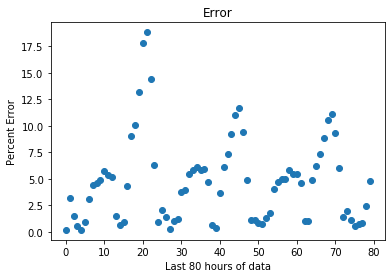

In [98]:
plt.scatter(np.arange(len(actual)),actual['percentage_error'])
plt.ylabel('Percent Error')
plt.xlabel('Last 80 hours of data')
plt.title('Error')

